# Bayesian Optimization

**Exercise:**

1.Choose a supervised learning algorithm with a large number of hyperparameters.

2.Select a data set and an objective function for evaluating the algorithm.

3.Implement the Bayesian optimization algorithm.

4.Compare the Bayesian optimization algorithm with random search.

5.Visualize the space of tested hyperparameter values. Color indicate the value of the objective function on them.

6.Visualize the value of the objective function depending on the step number.

 **Note:**

●The 5th and 6th steps should be performed for the Bayesian optimization and random search algorithm.

●You can use any enhancement function: UCB, PI or EI.

●You are allowed to use any surrogate function that is capable of estimating the uncertainty of the prediction. It is advisable to use random forest or Gaussian processes.

#installations and libraries

In [ ]:
!pip install arff
!pip install -U pymfe

  Preparing metadata (setup.py) ... done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4948 sha256=54d963aa9124450dfe93b89cceba98a3253a647091372125b6de2fa2fdeb6bb6
  Stored in directory: /root/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.7 MB/s eta 0:00:00


In [ ]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#1. Choosing supervised learning algorithm (Gradient Boosting)

In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelBinarizer
# from sklearn.preprocessing import MultiLabelBinarizer
def gbm(x, y, hyp_params):
  # y = np.asarray(y, dtype= str)
  x = pd.get_dummies(x)
  x = np.asarray(x)
  y = pd.get_dummies(y)
  encoder = LabelBinarizer()
  y = encoder.fit_transform(y)
  y = y.argmax(axis = 1)
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
  # 6 hyperparameters to set
  # print(x, y)
  gbc = GradientBoostingClassifier(n_estimators=int(hyp_params[0]), learning_rate=hyp_params[1],
																		subsample = hyp_params[2], min_samples_split = hyp_params[3],
																		min_weight_fraction_leaf = hyp_params[4], max_depth = int(hyp_params[5]),
																		random_state=0).fit(X_train, y_train)
  return gbc.score(X_test, y_test)

#2. Selecting a dataset and an objective function

###Selecting dataset

In [ ]:
from numpy.random import normal
from math import sin
from math import pi

# selecting datatset
from scipy.io import arff
file_path = '/content/11.arff'
data = arff.loadarff(file_path)
base_df = pd.DataFrame(data[0]).sample(frac = 1 )
base_df = base_df.dropna(how='any',axis=0)

# getting X and y
base_X = base_df.drop(base_df.keys()[-1], axis = 1)
base_y = base_df[base_df.keys()[-1]]
print('dataset length', len(base_y))

dataset length 625



### building hyperparameter dataset by applying random search

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'subsample', 'min_samples_split',
                             'min_weight_fraction_leaf', 'max_depth', 'score'
                        ])
from timeit import default_timer
from scipy.stats import loguniform


rs_start = default_timer()

import random
for i in range(50):
  row = []
  row.append(random.randint(1,200)) #n_estimators
  row.append(loguniform(0.01, 1.2).rvs()) #learning_rate random variate sample
  row.append(random.uniform(0.001, 1.0)) #subsample
  row.append(random.uniform(0.001, 0.999)) #min_samples_split
  row.append(random.uniform(0.0, 0.5)) #min_weight_fraction_leaf
  row.append(random.randint(1,100)) #max_depth
  # print(y)
  row.append(gbm(base_X, base_y, row)) #score
  # print(row)

  df = df.append(pd.DataFrame([row], columns=['n_estimators', 'learning_rate', 'subsample', 'min_samples_split',
                             'min_weight_fraction_leaf', 'max_depth', 'score'
                        ]),ignore_index=True)

rs_duration = default_timer() - rs_start
print(df['score'].max(), df['score'].min())
print('random search duration', rs_duration)

0.9323671497584541 0.4492753623188406
random search duration 25.790552704999996


In [ ]:
len(df['score'].unique()), df['score'].unique()

(16,
 array([0.44927536, 0.75362319, 0.46859903, 0.73913043, 0.76328502,
        0.93236715, 0.68599034, 0.57004831, 0.74879227, 0.68115942,
        0.81642512, 0.83574879, 0.67149758, 0.77777778, 0.9178744 ,
        0.90821256]))

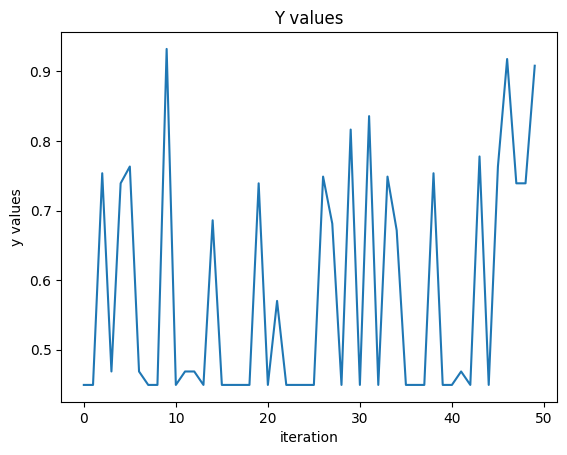

In [ ]:
plt.plot(range(len(df['score'])), np.asarray(df['score']))

# naming the x axis
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('y values')

# giving a title to my graph
plt.title('Y values')

# function to show the plot
plt.show()

###Objective function

In [ ]:
def objective(x):
  return gbm(base_X, base_y, x)

#3. Bayesian optimization algorithm implementation

##needed libaries

In [ ]:
# example of a gaussian process surrogate function
from math import sin
from scipy.stats import norm
from math import pi
from numpy import arange
from numpy import asarray
from numpy.random import normal
# from numpy.random import random
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from warnings import catch_warnings
from numpy import vstack
from warnings import simplefilter
from numpy import mean
from numpy import argmax
from sklearn.gaussian_process import GaussianProcessRegressor

##bayesian optimization process

In [ ]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
# from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
leng = 50
b_start = default_timer()
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		# print(X)
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
  # calculate the best surrogate score found so far
  yhat, _ = surrogate(model, X)
  best = max(yhat)
  # calculate mean and stdev via surrogate function
  mu, std = surrogate(model, Xsamples)
  # calculate the probability of improvement
  probs = norm.cdf((mu - best) / (std+1E-9))
  # print(probs)
  return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = []
	for i in range(200):
		row = []
		row.append(random.randint(1,200)) #n_estimators
		row.append(loguniform(0.01, 1.2).rvs()) #learning_rate random variate sample
		row.append(random.uniform(0.001, 1.0)) #subsample
		row.append(random.uniform(0.001, 0.999)) #min_samples_split
		row.append(random.uniform(0.0, 0.5)) #min_weight_fraction_leaf
		row.append(random.randint(1,100)) #max_depth
		# print(y)
		Xsamples.append(row)
	Xsamples = np.asarray(Xsamples)

	scores = acquisition(X, Xsamples, model)

	ix = argmax(scores)
	return Xsamples[ix]

X = np.asarray(df[df.keys()[:-1]])
y = np.asarray(df[df.keys()[-1]])
model = GaussianProcessRegressor()
model.fit(X, y)
for i in range(leng):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [x])
	X = np.vstack([X, x])
	y = np.append(y, [actual])
	model.fit(X, y)

b_duration = default_timer() - b_start
ix = argmax(y[leng:]) + leng
print(y[ix])
print(y[:leng].max())
print( 'improved ', int((y[ix]- y[:leng].max())*10000)/100, '%')
print('bayesian duration', b_duration)

0.966183574879227
0.9323671497584541
improved  3.38 %
bayesian duration 28.793705980999988


In [ ]:
len(np.unique(y[leng:])), np.unique(y[leng:])

(25,
 array([0.0821256 , 0.44927536, 0.46859903, 0.67149758, 0.68115942,
        0.70531401, 0.72463768, 0.73429952, 0.73913043, 0.74396135,
        0.74879227, 0.76328502, 0.82125604, 0.85024155, 0.87439614,
        0.87922705, 0.88405797, 0.88888889, 0.89855072, 0.90338164,
        0.91304348, 0.92270531, 0.95169082, 0.95652174, 0.96618357]))

#4. Comparing the Bayesian optimization algorithm with random search

In [ ]:
print('bayesian duration', b_duration)
print('random search duration', rs_duration)
print('difference in durations', b_duration - rs_duration)

bayesian duration 28.793705980999988
random search duration 25.790552704999996
difference in durations 3.003153275999992


In [ ]:
from pymfe.mfe import MFE
leng = 50
rs_mfe = MFE(groups=["statistical"]) #sd
rs_mfe.fit(X[:leng], y[:leng])
rs_ft = rs_mfe.extract()
b_mfe = MFE(groups=["statistical"])
b_mfe.fit(X[leng:], y[leng:])
b_ft = b_mfe.extract()
print("\n".join("{:50} {:20} {:20}".format(x, y, z) for x, y, z in zip(rs_ft[0], rs_ft[1], b_ft[1])))

can_cor.mean                                         0.5883171924425388   0.7554821143059937
can_cor.sd                                           0.1640693189721556  0.11668693950777505
cor.mean                                            0.14774173052601064  0.10349959509736525
cor.sd                                              0.08945059668988692  0.09221475457054848
cov.mean                                               2.65400609198453   2.7979838430143333
cov.sd                                                7.349877260030925    7.111562889917958
eigenvalues.mean                                       704.461393735407    696.7739522089411
eigenvalues.sd                                       1368.2255455078348   1459.5913848334442
g_mean.mean                                          20.617452158903642     20.6019543908495
g_mean.sd                                             34.83622162666488    33.35837287903381
gravity                                               53.6195206746194

In [ ]:
MFE.metafeature_description(groups=["statistical"])

+-------------+-------------------+--------------------------------------------+
|    Group    | Meta-feature name |                Description                 |
+=============+===================+============================================+
| statistical | can_cor           | Compute canonical correlations of data.    |
+-------------+-------------------+--------------------------------------------+
| statistical | cor               | Compute the absolute value of the          |
|             |                   | correlation of distinct dataset column     |
|             |                   | pairs.                                     |
+-------------+-------------------+--------------------------------------------+
| statistical | cov               | Compute the absolute value of the          |
|             |                   | covariance of distinct dataset attribute   |
|             |                   | pairs.                                     |
+-------------+-------------

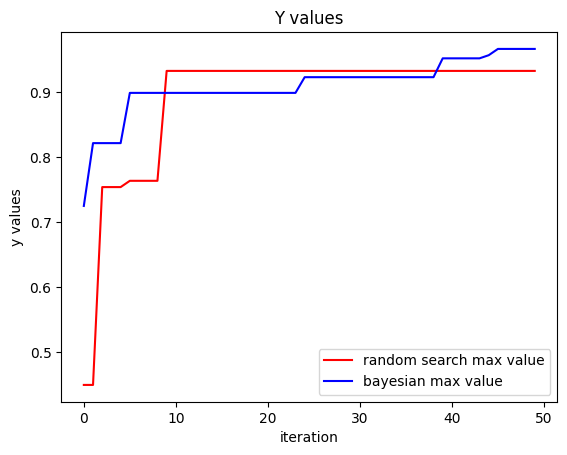

In [ ]:
random_search_imp = []
bayesian_imp = []
leng = 50
for yi in range(len(y[:leng])):
  random_search_imp.append(y[:yi+1].max())
  bayesian_imp.append(y[leng:yi + leng + 1].max())
plt.plot(range(len(random_search_imp)), random_search_imp, color= 'red', label = 'random search max value')
# plt.plot(range(len(random_search_imp)), y[:30], color= 'pink', label = 'random search values')
plt.plot(range(len(random_search_imp)), bayesian_imp, color='blue', label = 'bayesian max value')
# plt.plot(range(len(random_search_imp)), y[30:], color='lightblue', label = 'bayesian values')

# naming the x axis
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('y values')

plt.legend()
# giving a title to my graph
plt.title('Y values')

# function to show the plot
plt.show()

#5. Visualizing the space of tested hyperparameter values

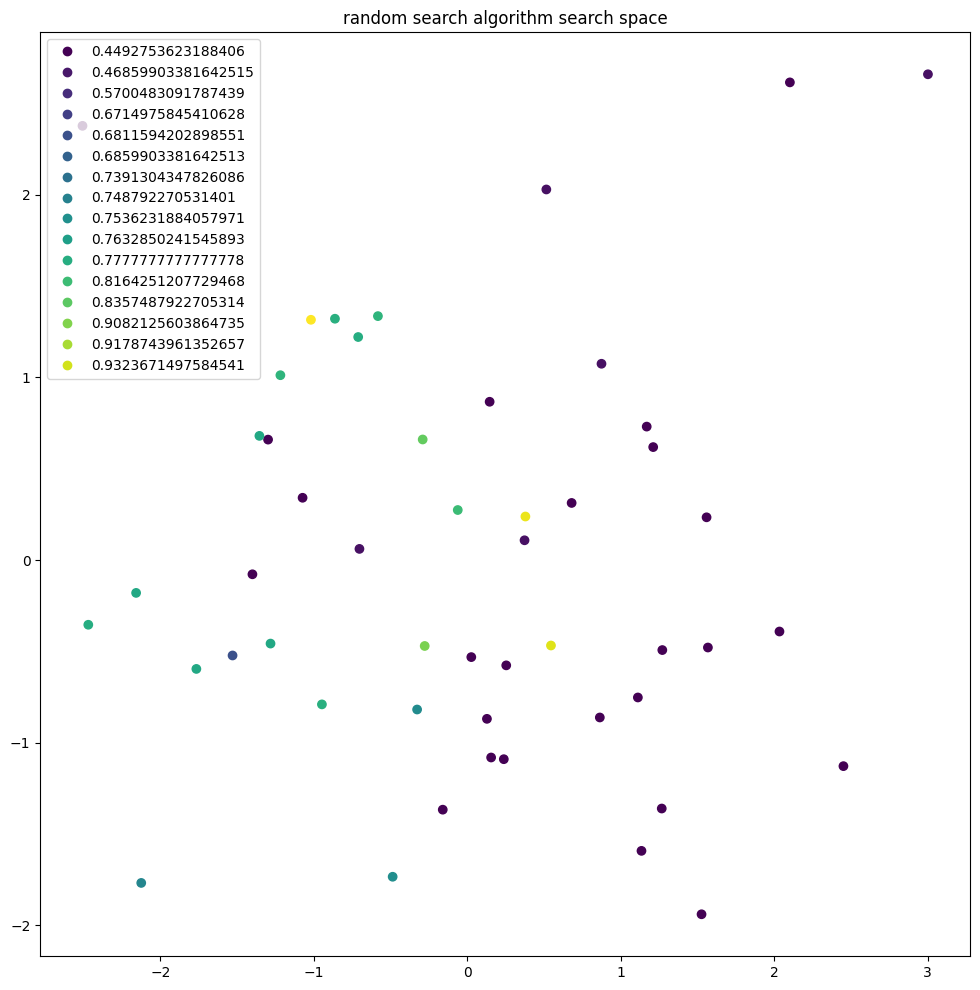

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

digitsdata = load_digits()
X1, y1 =X[:leng], y[:leng]
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(12,12))
Xt = pipe.fit_transform(X1)
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y1)
plt.legend(handles = plot.legend_elements(num=len(np.unique(y1)))[0], labels=list(np.unique(y1)))
plt.title('random search algorithm search space')
# plt.legend(handles=plot.legend_elements()[0], labels=list(np.unique(y1)))
plt.show()

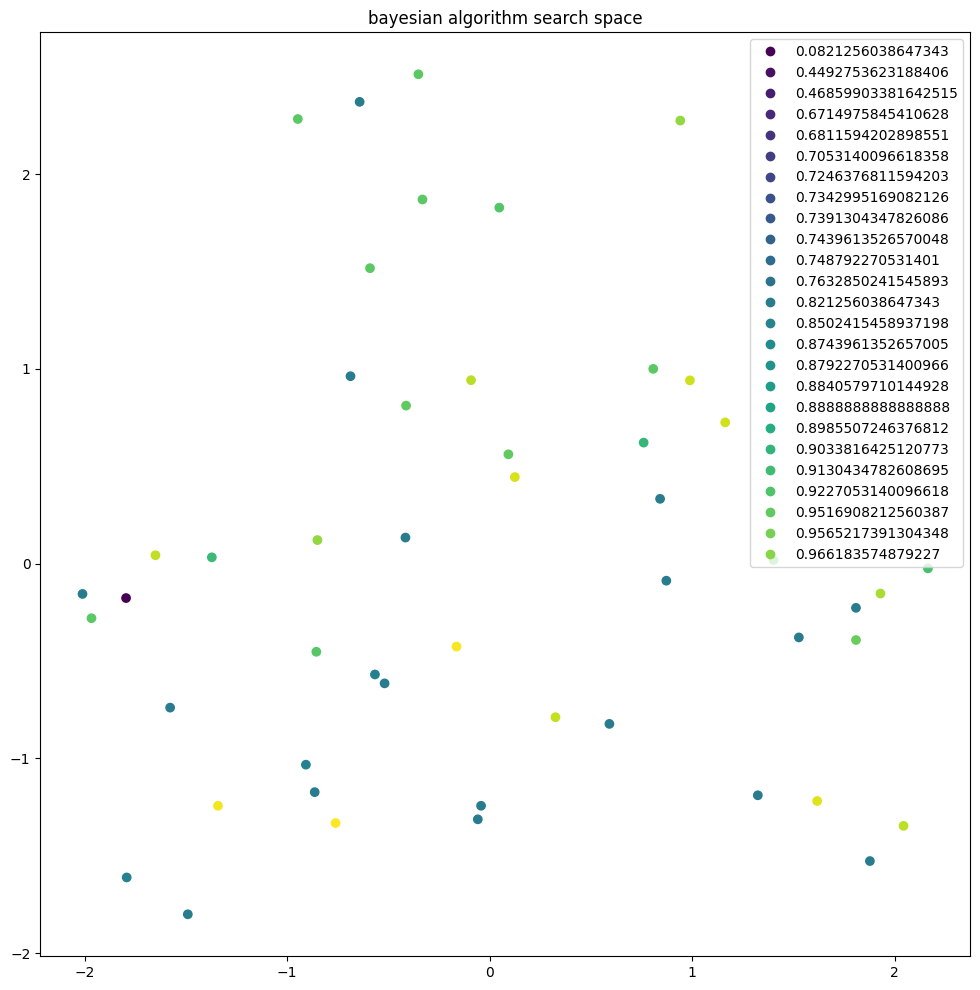

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

digitsdata = load_digits()
X1, y1 =X[leng:], y[leng:]
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(12,12))
Xt = pipe.fit_transform(X1)
plot = plt.scatter(Xt[:,0], Xt[:,1], c = y1)
plt.legend(handles = plot.legend_elements(num=len(np.unique(y1)))[0], labels=list(np.unique(y1)))
plt.title('bayesian algorithm search space')
# plt.legend(handles=plot.legend_elements()[0], labels=list(np.unique(y1)))
plt.show()

#6. Visualizing the value of the objective function

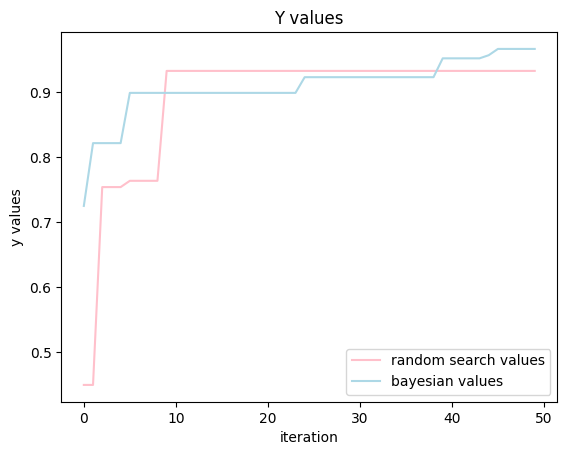

In [ ]:
random_search_imp = []
bayesian_imp = []
leng = 50
for yi in range(len(y[:leng])):
  random_search_imp.append(y[:yi+1].max())
  bayesian_imp.append(y[leng:yi + leng + 1].max())
# plt.plot(range(len(y[:leng])), y[:leng], color= 'red', label = 'random search')
plt.plot(range(len(random_search_imp)), random_search_imp, color= 'pink', label = 'random search values')
# plt.plot(range(len(y[leng:])), y[leng:], color='gray', label = 'bayesian')
plt.plot(range(len(bayesian_imp)), bayesian_imp, color='lightblue', label = 'bayesian values')

# naming the x axis
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('y values')

plt.legend()
# giving a title to my graph
plt.title('Y values')

# function to show the plot
plt.show()

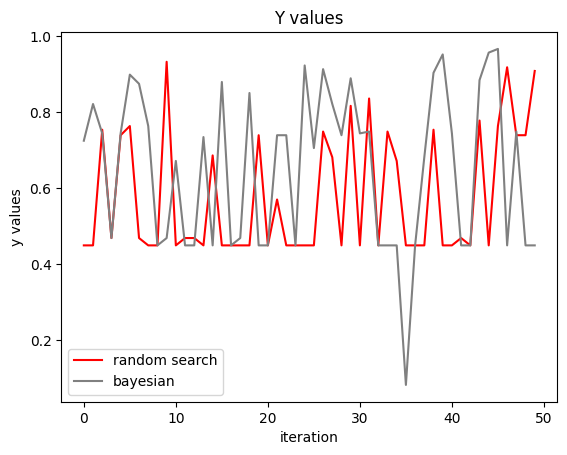

In [ ]:
random_search_imp = []
bayesian_imp = []
leng = 50
for yi in range(len(y[:leng])):
  random_search_imp.append(y[:yi+1].max())
  bayesian_imp.append(y[leng:yi + leng + 1].max())
plt.plot(range(len(y[:leng])), y[:leng], color= 'red', label = 'random search')
# plt.plot(range(len(random_search_imp)), random_search_imp, color= 'pink', label = 'random search values')
plt.plot(range(len(y[leng:])), y[leng:], color='gray', label = 'bayesian')
# plt.plot(range(len(bayesian_imp)), bayesian_imp, color='lightblue', label = 'bayesian values')

# naming the x axis
plt.xlabel('iteration')
# naming the y axis
plt.ylabel('y values')

plt.legend()
# giving a title to my graph
plt.title('Y values')

# function to show the plot
plt.show()